# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.simfunc.simulation import Simulation  # class for simulation
from src.utils.optimizer import custmin  # custom minimizer
from src.utils.simparam import SimParam  # class for simulation parameters
from src.utils.utils import day_graph, minutes_to_hms

%matplotlib inline
%config InlineBackend.figure_format='retina'

# T1reno

In [2]:
# get FY2019 data
data = pd.read_excel(
    io="/home/antoine/projects/pax-flow-sim/data/raw/FY2019_FY2025 merge.xlsx",
    header=0,
    sheet_name="IntlP_FY19-FY25",
)

# 7kPax/hour std schedule
simparamT1 = SimParam()
path_to_6k_sched = (
    r"/home/antoine/projects/pax-flow-sim/data/processed/Schedule (30th terminal"
    r" peak, 6000 pax)_PROCESSED.xlsx"
)
simparamT1.schedule_from_path(path_to_6k_sched)

In [3]:
# APJ at T2 correction
simparamT1.schedule.loc[
    simparamT1.schedule["Flight Number"].apply(lambda x: x.split(" ")[0]) == "APJ",
    "T1/T2(MM/9C/7C/TW)",
] = "T2"

In [4]:
simparamT1.plot_name = "T1"

In [5]:
simparamT1.schedule_cleanup().schedule_filter()
simparamT1.assign_check_in()
simparamT1.show_up_from_file().assign_flight_show_up_category_default().assign_show_up()

# FY19

In [6]:
# format the file from aero
mask2019 = (data["FY"] == "FY2019") & (data["Day Of Week"] == "Saturday")
data2019 = data[mask2019].reset_index().copy()
data2019["Sector"] = data2019["Int/Dom"]
data2019["Flight Date"] = pd.to_datetime("2019-10-13")
data2019["Scheduled Time"] = data2019["5min Interval"].apply(
    lambda x: f"{x // 100}:{x % 100}:00",
)
data2019["Category(P/C/O)"] = data2019["Category(P/C/O)"].apply(lambda x: x[0])

# create simparam2019
simparam2019 = SimParam()
simparam2019.schedule_from_df(data2019).schedule_cleanup().schedule_filter(
    date_str="2019-10-13"
).assign_check_in()
simparam2019.show_up_from_file().assign_flight_show_up_category_default().assign_show_up()
# define plot name
simparam2019.plot_name = "FY19"

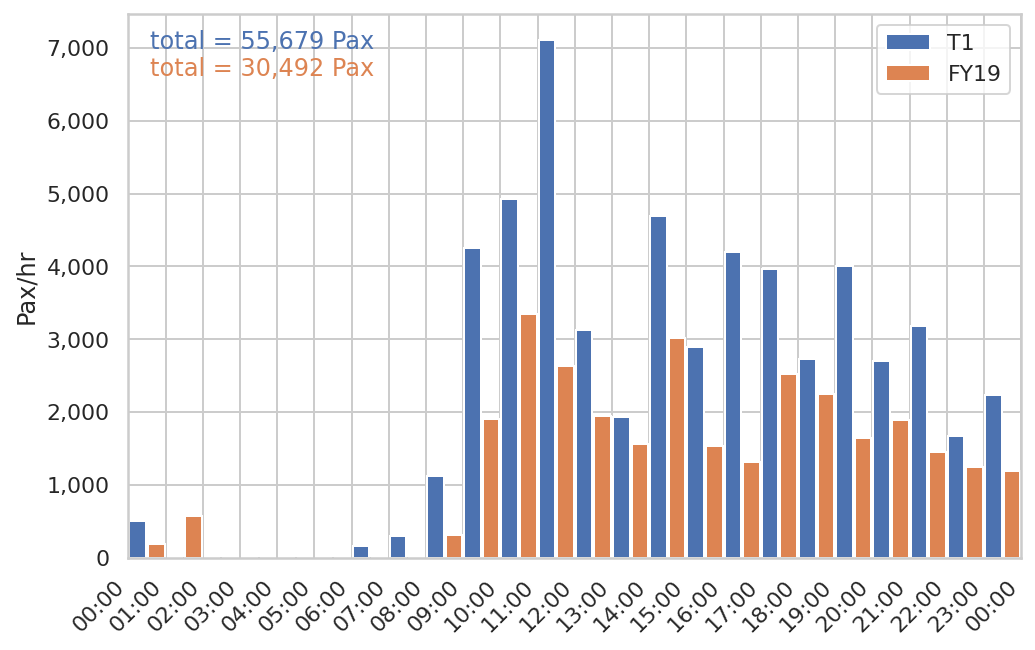

In [8]:
simparamT1.plot_std(compare_with=[simparam2019])

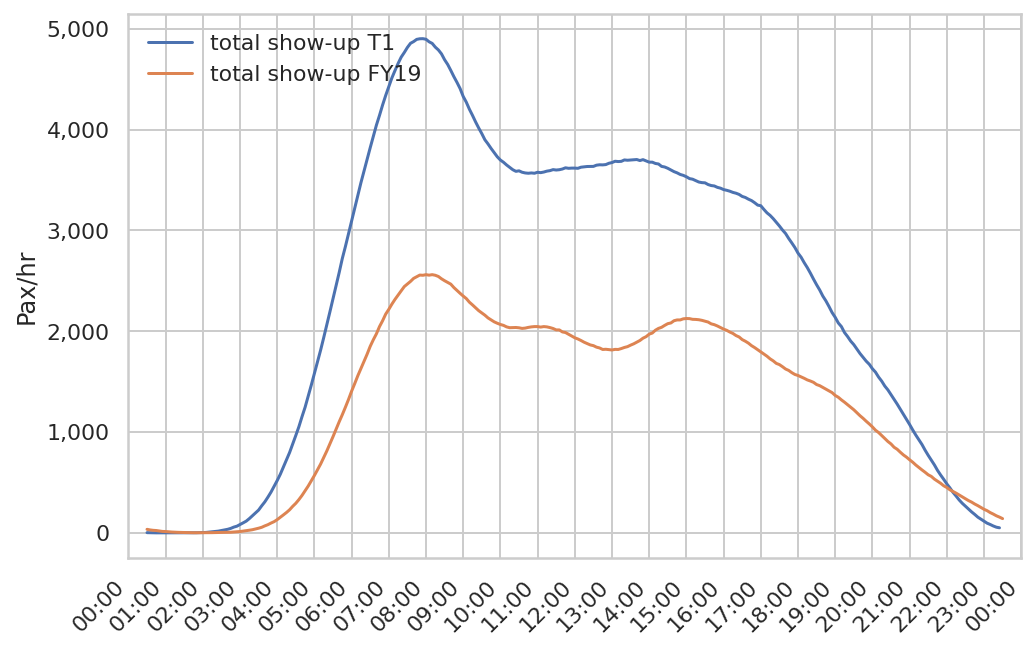

In [14]:
simparamT1.plot_df_Pax(compare_with=simparam2019)

# FY23-26

In [ ]:
# FY2022-25 data
years = [2023, 2024, 2025, 2026]
dct_data = {
    year: pd.read_excel(
        f"/home/antoine/projects/pax-flow-sim/data/raw/FY{year} KIX schedule"
        " forecast.xlsx",
        sheet_name="ALLdata",
        header=1,
    )
    for year in years
}
dct_data_processed = {}
dct_simparam = {}

# table should be formatted with following columns
# | A/D | T1/T2(MM/9C/7C/TW) | Intl Regions | Category(P/C/O) | Sector |
# | Flight Number | SEATS FC | PAX_SUM FC | Flight Date | Scheduled Time |

for key, data in dct_data.items():
    data["T1/T2(MM/9C/7C/TW)"] = data["Terminal"].replace(
        {"N": "T1", "S": "T1", 1: "T1", "L": "T2", np.nan: "-"}
    )

    data["Category(P/C/O)"] = data["Flight Type"].apply(lambda x: x[0])

    dct_name_change = {
        "Int / Dom": "Sector",
        "Int P Region": "Intl Regions",
        "Fight Number": "Flight Number",  # <- to be split with space between letters and digits
        "Seats": "SEATS FC",
        "PAX": "PAX_SUM FC",
        "Date": "Flight Date",
        "Time": "Scheduled Time",
    }

    dct_data_processed[key] = data.rename(columns=dct_name_change)

for key, data_processed in dct_data_processed.items():
    dct_simparam[key] = SimParam()
    dct_simparam[key].schedule_from_df(
        data_processed
    ).schedule_cleanup().schedule_filter(date_str=f"{key}-12-20").assign_check_in()
    dct_simparam[key].plot_name = f"FY{key%100}"

In [ ]:
# plot both for comparison
simparamT1.plot_std(compare_with=[simparam2019, dct_simparam[2024]])

In [ ]:
simparamT1.plot_counters(compare_with=[simparam2019, dct_simparam[2024]])

In [ ]:
dct_simparam[2024].schedule["Airline Code"].unique()

In [ ]:
# airlines from survey
selected_ALs = [
    [  # Pattern 1: All Green for CUSBD & CUCkIn
        "AAR",
        "ACA",
        "CCA",
        "CPA",
        "CQH",
        "CRK",
        "CSC",
        "CSZ",
        "CXA",
        "EVA",
        "GCR",
        "JJA",
        "JJP",
        "JST",
        "SJX",
        "TAX",
        "XAX",
    ],
    [  # Pattern 2: Not Negative for CUSBD & CUCkIn
        "AAR",
        "ACA",
        "AMU",
        "ANA",
        "ANZ",
        "BAW",
        "CAL",
        "CBJ",
        "CCA",
        "CEB",
        "CES",
        "CPA",
        "CQH",
        "CRK",
        "CSC",
        "CSH",
        "CSN",
        "CSZ",
        "CXA",
        "DKH",
        "DLH",
        "EVA",
        "FIN",
        "GCR",
        "GIA",
        "HKE",
        "JJA",
        "JJP",
        "JNA",
        "JSA",
        "JST",
        "OKA",
        "SJX",
        "SWR",
        "TAX",
        "THA",
        "TLM",
        "UAE",
        "XAX",
    ],
    [  # Pattern 3: Agree on CUSBD
        "AAR",
        "ABL",
        "ACA",
        "AMU",
        "ANA",
        "ANZ",
        "CAL",
        "CEB",
        "CES",
        "CPA",
        "CQH",
        "CSC",
        "CSH",
        "CXA",
        "DKH",
        "EVA",
        "FIN",
        "GCR",
        "HKE",
        "JAL",
        "JJA",
        "JJP",
        "JNA",
        "JSA",
        "JST",
        "KAL",
        "MAS",
        "OKA",
        "SIA",
        "SJX",
        "TAX",
        "TWB",
        "UAE",
        "XAX",
    ],
    [  # Pattern 4: Not disagree on CUSBD
        "AAR",
        "ABL",
        "ACA",
        "AFR",
        "AMU",
        "ANA",
        "ANZ",
        "CAL",
        "CCA",
        "CDC",
        "CEB",
        "CES",
        "CPA",
        "CQH",
        "CRK",
        "CSC",
        "CSH",
        "CSZ",
        "CXA",
        "DKH",
        "EVA",
        "FIN",
        "GCR",
        "GIA",
        "HKE",
        "JAL",
        "JJA",
        "JJP",
        "JNA",
        "JSA",
        "JST",
        "KAL",
        "KLM",
        "MAS",
        "OKA",
        "SIA",
        "SJX",
        "TAX",
        "TWB",
        "UAE",
        "XAX",
    ],
]

In [ ]:
# Most likely case
airlines_CU = selected_ALs[2]
simparamT1.df_Pax["pax_type"] = simparamT1.df_Pax["Airline"].apply(
    lambda x: "CUSBD" if x in airlines_CU else "tradi"
)
simparamT1.schedule["pax_type"] = simparamT1.schedule["Airline Code"].apply(
    lambda x: "CUSBD" if x in airlines_CU else "tradi"
)
simparamT1.plot_std(
    by_col=True, col_name="pax_type", compare_with=simparam2019, reverse_cat=True
)

In [ ]:
# simulation of waiting times
simparamT1.dct_resource = {
    "kiosk": 92,
    "CUSBD": 32,
}

simparamT1.dct_processes = {
    "kiosk": 70,
    "CUSBD": 60,
    "checkin": 80,
}

simparamT1.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 2.5},
    ],
}

In [ ]:
simulationT1_pat3 = Simulation(simparamT1)
simulationT1_pat3.generate_checkin().generate_pax().run()
simulationT1_pat3.format_df_result()

In [ ]:
simulationT1_pat3.plot_result()

In [ ]:
# simulation of waiting times
simparam2019.dct_resource = {
    "kiosk": 92,
    "CUSBD": 32,
}

simparam2019.dct_processes = {
    "kiosk": 70,
    "checkin": 80,
}

simparam2019.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
}

In [ ]:
simparam2019.df_Pax["pax_type"] = "tradi"
simulation2019 = Simulation(simparam2019)

In [ ]:
simulation2019.generate_checkin().generate_pax().run()

In [ ]:
simulation2019.format_df_result()

In [ ]:
simulation2019.plot_result(same_scale_as=simulationT1_pat3)
simulationT1_pat3.plot_result(same_scale_as=simulation2019)

# cost function test for N

In [ ]:
# in this part, we will try to find the optimal number of CUSBD (N)
# to have the target waiting time (top90%=10 minutes)
# this is an exercize of minimizing the result of a cost function
# We create the cost function that takes N as argument and will output
# the "cost". the "cost" will be big when waiting time is different from target
# and low when waiting time is close to target (see below)
def cost_func(
    simparam: SimParam,
    target: float,  # target value for waiting time
    resource: str,  # name of the process
    N,  # N that will be tested
):
    """
    cost function for target waiting time depenging on variable
    variable can be any of simparam attributes
    cost is only based on waiting time but can be improved in the future
    """

    # set number of resource to N
    simparam.dct_resource[resource] = N

    # test to keep the latest simulation run in memory
    global simulation_last

    # run the simulation and get the results
    simulation_last = Simulation(simparam)
    simulation_last.generate_checkin().generate_pax().run()
    simulation_last.format_df_result()

    # evaluate the cost for given criteria: we use simple square distance
    cost = (simulation_last.dct_hist_wait_time[resource].quantile(q=0.9) - target) ** 2

    # it is important to have a convex(?) function
    # so we need to make sure the extremities have a slope
    # if nobody waits, penalize high N
    if simulation_last.dct_hist_wait_time[resource].quantile(q=0.9) == 0:
        cost += N / 1000

    # if the top90% Pax waits 8hrs or more, penalize low N
    if simulation_last.dct_hist_wait_time[resource].quantile(q=0.9) >= 7.9 * 60:
        cost -= N / 1000

    return cost

In [ ]:
# optimize
f = lambda N: cost_func(
    simparam=simparamT1,
    target=10,
    resource="CUSBD",
    N=N,
)
# "custmin" stands for custom minimizer
# it is a small function writtent to find minimum
# of a convex function
# in a very simple way with steps
res = custmin(
    f,
    guess=40,
    steps=[1],
)
print(res)

# the cost function keeps the global simulation_last in memory to be able
# to plot the graph of the last simulation run by custmin
simulation_last.plot_result()

# if early check-in for CUSBD

In [ ]:
simparamT1_earlyCUSBD = deepcopy(simparamT1)

simparamT1_earlyCUSBD.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 3.5},
    ],
}

In [ ]:
# optimize
f = lambda N: cost_func(
    simparam=simparamT1_earlyCUSBD,
    target=10,
    resource="CUSBD",
    N=N,
)
res = custmin(
    f,
    guess=35,
    steps=[1],
)
print(res)

simulation_last.plot_result()

# if early checkin tradi + cusbd


In [ ]:
simparamT1_earlyall = deepcopy(simparamT1)

# let's set the optimum number of CUSBD
simparamT1_earlyall.dct_resource = {
    "kiosk": 92,
    "CUSBD": 41,
}

# set opening time to 3.5 hours before std
simparamT1_earlyall.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 3.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 3.5},
    ],
}

# change allocation rule for tradi counters
simparamT1_earlyall.assign_check_in(
    base_n_counter=3,
    onecounter_time=0.75,
    seats_per_add_counter=110,
    start_time=3.5,
)

In [ ]:
# plot the number of counter saved
airlines_tradi = [
    al
    for al in simparamT1_earlyall.df_Counters.columns
    if al not in airlines_CU and al != "total"
]
simparamT1_earlyall.df_Counters[airlines_tradi].sum(axis=1).plot()
simparamT1_earlyCUSBD.df_Counters[airlines_tradi].sum(axis=1).plot()

In [ ]:
# let's check the waiting time to confirm they are still OK
simulationT1_earlyall = Simulation(simparamT1)
simulationT1_earlyall.generate_checkin().generate_pax().run()
simulationT1_earlyall.format_df_result()

In [ ]:
simulationT1_earlyall.plot_result()